## Chapter 6: Linear two-class classification

# 6.5  Support Vector Machines

In this Section we begin by discussing an often used variation of the perceptron called the *margin perceptron*.  This perspective extends the notion of the perceptron described in the previous Section under the assumption that a dataset is linearly separable.  The margin perceptron will lead us to discuss *Support Vector Machines*, a popular perspective on linear classification again under the assumption of linear seperability.  This approach provides interesting theoretical insight into the two-class classification process - particularly under the assumption that the data is linearly seperable.  However we will see that in practice the Support Vector Machines approach does not provide a learned decision boundary that substantially differs from those provided by logistic regression or, likewise, the perceptron.  

In [1]:
# append path for local library, data, and image import
import sys
sys.path.append('./chapter_6_library')
sys.path.append('./chapter_6_datasets') 
sys.path.append('./chapter_6_images') 

# import section helper
import section_6_5_helpers

# dataset paths
data_path_1 = 'chapter_6_datasets/svm_demo_data.csv'

# image paths
image_path_1 = 'chapter_6_images/Fig_4_4_new.png'
image_path_2 = 'chapter_6_images/Fig_4_13.png'
image_path_3 = 'chapter_6_images/Fig_4_14_new.png'

# standard imports
import matplotlib.pyplot as plt
import IPython

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## The margin-perceptron

Suppose once again that we have a two-class classification training dataset of $P$ points $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ with the labels $y_p \in \{-1,+1\}$.  Suppose for the time being that we are dealing with a two-class dataset that is linearly separable with a known linear decision boundary

\begin{equation}
\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,} = 0.
\end{equation}

Suppose even further that this decision boundary passes evenly through the region separating our two classes, like the illustrated in the figure below.  

In [2]:
IPython.display.HTML('''<img src="''' + image_path_1 + '''" width="60%" height="auto" alt=""/>''')

<figure>
  <figcaption>   
<strong>Figure 1:</strong> <em> For linearly separable data the width of the buffer zone (in gray) confined between two evenly spaced translates of a separating hyperplane that just touch each respective class, defines the margin of that separating hyperplane.</em>  </figcaption> 
</figure>

This separating hyperplane creates a buffer between the two classes confined between two evenly shifted versions of itself: one version that lies on the positive side of the separator and just touches the class having labels $y_{p}=+1$ (colored red in the figure) taking the form $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}  =+1$, and one lying on the negative side of it just touching the class with labels $y_{p}=-1$ (colored blue in the figure) taking the form $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,} =-1$.  The translations above and below the separating hyperplane are more generally defined as $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,} =+\beta^{\,}$ and $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,} =-\beta^{\,}$ respectively, where $\beta>0$. However by dividing off $\beta$ in both equations and reassigning the variables as $\mathbf{w}^{\,}\longleftarrow\frac{\mathbf{w}^{\,}}{\beta}$ we can leave out the redundant parameter $\beta$ and have the two translations as stated $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}=\pm1$. 

The fact that all points in the $+1$ class lie exactly on or on the positive side of $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}=+1$, and all points in the $-1$ class lie exactly on or on the negative side of $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}=-1$ can be written formally as the following conditions

\begin{equation}
\begin{array}{cc}
\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\geq1 & \,\,\,\,\text{if} \,\,\, y_{p}=+1\\
\,\,\,\, \mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\leq-1 & \,\,\,\,\text{if} \,\,\, y_{p}=-1
\end{array}
\end{equation}

We can combine these conditions into a single statement by multiplying each by their respective label values, giving the single inequality $y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\geq1$ which can be equivalently written as a point-wise cost

\begin{equation}
g_p\left(\mathbf{w}\right) = \mbox{max}\left(0,\,1-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right)=0
\end{equation}

Again, this value is always nonnegative. Summing up all $P$ equations of the form above gives the *Margin-Perceptron* cost

\begin{equation}
g\left(\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\mbox{max}\left(0,\,1-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right)
\end{equation}

Notice the striking similarity between the original perceptron cost from the previous post and the margin perceptron cost above: naively we have just 'added a $1$' to the non-zero input of the max function in each summand. However this additional $1$ prevents the issue of a trivial zero solution with the original perceptron discussed previously, which simply does not arise here. 

If the data is indeed linearly separable any hyperplane passing between the two classes will have parameters $\mathbf{w}$ where $g\left(\mathbf{w}\right)=0$. However the margin perceptron is still a valid cost function even if the data is not linearly separable. The only difference is that with such a dataset we can not make the criteria above hold for all points in the dataset. Thus a violation for the $p^{\textrm{th}}$ point adds the positive value of $1-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}$ to the cost function.

## The softmax and Margin-Perceptron cost

Modeling and optimization go hand-in-hand. If we have modeled something well but the associated cost function is difficult to minimize it can be more expedient to re-fashion the cost, even if we lose considerable modeling precision, if the new cost function is considerably easier to optimize.  Here 'easier to optimize' could mean a number of things - perhaps a steplength parameter is less sensitive (meaning a larger range of potential values will provide good results), or a broader set of optimization tools can be brought to bear.  The opposite holds as well - a cost function that is easy to minimize but models no useful phenomenon is a mere curiosity.

Here we find ourselves in-between these two extremes, with a cost function that can be slightly adjusted to enable a broader set of optimization tools (including a larger range of steplength values for gradient descent, as well as Newton's method) while losing only a small portion of its original shape.  As with the perceptron, one way to smooth out the margin-perceptron here is by replacing the $\text{max}$ operator with $\text{softmax}$. Doing so in one summand of the margin-perceptron gives the related summand

\begin{equation}
\text{soft}\left(0,1-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right) = \text{log}\left( 1 + e^{1-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}}\right)
\end{equation}

Right away if we were to sum over all $P$ we could form a softmax-based cost function that closely matches the margin-perceptron.  But note how in the derivation of the margin perceptron the '1' used in the $1-y_{p}^{\,}\left(\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right)$ component of the cost could have been any number we wanted - it was a normalization factor for the width of the margin and, by convention, we used '1'.  

Instead we could have chosen any value $\epsilon > 0$ in which case the set of $P$ conditions stated in equation (2) would be equivalently stated as

\begin{equation}
\mbox{max}\left(0,\,\epsilon-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right)=0
\end{equation}

for all $p$ and the Margin-Perceptron equivalently stated as 

\begin{equation}
g\left(\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\mbox{max}\left(0,\,\epsilon-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right)
\end{equation}

and the softmax version of one summand here being

\begin{equation}
\text{soft}\left(0,\epsilon-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right) = \text{log}\left( 1 + e^{\epsilon-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}}\right)
\end{equation}

When $\epsilon$ is quite small we of course have that $\text{log}\left( 1 + e^{\epsilon-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}}\right) \approx \text{log}\left( 1 + e^{-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}}\right)$, the same summand used for the (smoothed) perceptron and logistic regression.  Thus we can in fact use the same softmax cost function here

\begin{equation}
g\left(\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\text{log}\left( 1 + e^{-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}}\right)
\end{equation}

as a smoothed version of our Margin-Perceptron cost. 

From the perspective of the standard perceptron this realization is somewhat redundant - a decision boundary recovered via the perceptron on a linearly separable dataset will almost always have a non-zero margin. So this just says its smoothed version will do the same.

##   A quest for the hyperplane with maximum margin

When two classes of data are linearly separable infinitely many hyperplanes could be drawn to separate the data. In the figure below we display two such hyperplanes for a given synthetic dataset. Given that both classifiers (as well as any other decision boundary perfectly separating the data) would perfectly classify the data, is there one that we can say is the 'best' of all possible separating hyperplanes?  

One reasonable standard for judging the quality of these hyperplanes is via their margin lengths, that is the distance between the evenly spaced translates that just touch each class. The larger this distance is the intuitively better the associated hyperplane separates the entire space given the particular distribution of the data. This idea is illustrated pictorially in the figure below.

In [3]:
IPython.display.HTML('''<img src="''' + image_path_2 + '''" width="35%" height="auto" alt=""/>''')

<figure>
  <figcaption>   
<strong>Figure 2:</strong> <em> Of the infinitely many hyperplanes that exist between two classes of linearly separable data the one with maximum margin does an intuitively better job than the rest at distinguishing between classes because it more equitably partitions the entire space based on how the data is distributed. In this illustration two separators are shown along with their respective margins. While both perfectly distinguish between the two classes the green separator (with smaller margin) divides up the space in a rather awkward fashion given how the data is distributed, and will therefore tend to more easily misclassify future datapoints. On the other hand, the black separator (having a larger margin) divides up the space more evenly with respect to the given data, and will tend to classify future points more accurately.</em>  </figcaption> 
</figure>

In our venture to recvoer the maximum margin seperating hyperplane, it will be convenient to use our individual notation for the bias and feature-touching weights (used in e.g., [Section 6.2](https://jermwatt.github.io/machine_learning_refined/notes/6_Linear_twoclass_classification/6_2_Cross_entropy.html))

\begin{equation}
\text{(bias):}\,\, b = w_0 \,\,\,\,\,\,\,\, \text{(feature-touching weights):} \,\,\,\,\,\, \boldsymbol{\omega} = 
\begin{bmatrix}
w_1 \\
w_2 \\ 
\vdots \\
w_N
\end{bmatrix}.
\end{equation}

With this notation we can express a linear decision boundary as

\begin{equation}
\mathring{\mathbf{x}}_{\,}^T \mathbf{w} = b + \overset{\,}{\mathbf{x}}_{\,}^T\boldsymbol{\omega} = 0.
\end{equation}

To find the separating hyperplane with maximum margin we aim to find a set of parameters so that the region defined by $b+\mathbf{x}^{T}\boldsymbol{\omega}^{\,}=\pm1$, with heach translate just touching one of the two classes, has the largest possible margin.  As shown in the figure below the margin can be determined by calculating the distance between any two points (one from each translated hyperplane) both lying on the normal vector $\boldsymbol{\omega}$. Denoting by $\mathbf{x}_{1}$ and $\mathbf{x}_{2}$ the points on vector $\boldsymbol{\omega}$ belonging to the *positive* and *negative* translated hyperplanes, respectively, the margin is computed simply as the length of the line segment connecting $\mathbf{x}_{1}$ and $\mathbf{x}_{2}$, i.e., $\left\Vert \mathbf{x}_{1}-\mathbf{x}_{2}\right\Vert _{2}$. 

In [4]:
IPython.display.HTML('''<img src="''' + image_path_3 + '''" width="60%" height="auto" alt=""/>''')

<figure>
    <figcaption>   
<strong>Figure 3:</strong> <em> The margin of a
separating hyperplane can be calculated by measuring the distance
between the two points of intersection of the normal vector $\boldsymbol{\omega}$
and the two equidistant translations of the hyperplane. This distance
can be shown to have the value of $\frac{2}{\left\Vert \boldsymbol{\omega}\right\Vert _{2}}$
(see text for further details). </em>  </figcaption> 
</figure>

The margin can be written much more conveniently by taking the difference of the two translates evaluated at $\mathbf{x}_{1}$ and $\mathbf{x}_{2}$ respectively, as 

\begin{equation}
\left(w_0^{\,} + \mathbf{x}_{1}^T\mathbf{w}^{\,}\right) - \left(w_0^{\,} + \mathbf{x}_{2}^T\mathbf{w}^{\,}\right) =\left(\mathbf{x}_{1}^{\,}-\mathbf{x}_{2}^{\,}\right)^{T}\boldsymbol{\omega}=2
\end{equation}

Using the inner product rule, and the fact that the two vectors $\mathbf{x}_{1}-\mathbf{x}_{2}$ and $\boldsymbol{\omega}$ are parallel to each other, we can solve for the margin directly in terms of $\boldsymbol{\omega}$, as 

\begin{equation}
\left\Vert \mathbf{x}_{1}-\mathbf{x}_{2} \right\Vert _2=\frac{2}{\left\Vert \boldsymbol{\omega}\right\Vert _{2}}
\end{equation}

Therefore finding the separating hyperplane with maximum margin is equivalent to finding the one with the smallest possible normal vector $\boldsymbol{\omega}$. 

##  The hard-margin and soft-margin SVM problems

In order to find a separating hyperplane for the data with minimum length normal vector we can simply combine our desire to minimize $\left\Vert \boldsymbol{\omega}\right\Vert _{2}^{2}$ subject to the constraint
(defined by the margin-perceptron) that the hyperplane perfectly separates the data (given by the margin criterion described above). This gives the so-called *hard-margin support vector machine* problem

\begin{equation}
\begin{aligned}\underset{b,\,\boldsymbol{\omega}}{\mbox{minimize}} & \,\,\left\Vert \boldsymbol{\omega}\right\Vert _{2}^{2}\\
\mbox{subject to} & \,\,\,\text{max}\left(0,\,1-y_{p}^{\,}\left(b+\mathbf{x}_{p}^{T}\boldsymbol{\omega}\right) \right)=0,\,\,\,\,p=1,...,P.
\end{aligned}
\end{equation}

The set of constraints here are precisely the margin-perceptron guarantee that the hyperplane we recover separates the data perfectly. Unlike some of the other constrained optimization problems we have previously discussed (see e.g., those described in our post on *general steepest descent methods* in our series on *mathematical optimization*) this cannot be solved in closed form, but must be optimized iteratively.

While there are *constrained optimization* algorithms that are designed to solve problems like this as stated, we can also solve the hard-margin problem by *relaxing* the constraints and forming an unconstrained formulation of the problem (to which we can apply familiar algorithmic methods to minimize).  To do this we merely bring the constraints up, forming a single cost function 

\begin{equation}
g\left(b,\boldsymbol{\omega}\right)=\underset{p=1}{\overset{P}{\sum}}\text{max}\left(0,\,1-y_{p}^{\,}\left(b+\mathbf{x}_{p}^{T}\boldsymbol{\omega}\right) \right) +  \lambda \left \Vert\boldsymbol{\omega}\right\Vert _{2}^{2}
\end{equation}

to be minimized. Here the parameter $\lambda\geq0$ is called a penalty or regularization parameter (we have seen the notion of regularization in the previous Section as well).  When $\lambda$ is set to a small positive value we put more 'pressure' on the cost function to make sure the constraints

\begin{equation}
\text{max}\left(0,\,1-y_{p}^{\,}\left(b+\mathbf{x}_{p}^{T}\boldsymbol{\omega}\right) \right)=0,\,\,\,\,p=1,...,P
\end{equation}

indeed hold, and (in theory) when $\lambda$ is made very small the formulation above matches the original constrained form.  Because of this $\lambda$ is often set to be quite small in practice.

This *regularized* form of the Margin-Perceptron cost function is referred to as the *soft-margin support vector machine cost*.  

#### <span style="color:#a50e3e;">Example 1: </span>  Comparing the SVM decision boundary on linearly separable data

In this example we compare the support vector machine decision boundary learned to three boundaries learned via the margin-perceptron.  All of the recovered boundaries perfectly separate the two classes, but the support vector machine decision boundary is the one that provides the maximum margin (right panel) while those recovered by the margin-perceptron (left panel, each colored differently) can ostensibly be any of the infinitely many linear decision boundaries that separate the two classes. 

/usr/local/lib/python3.8/dist-packages/autograd/tracer.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return f_raw(*args, **kwargs)


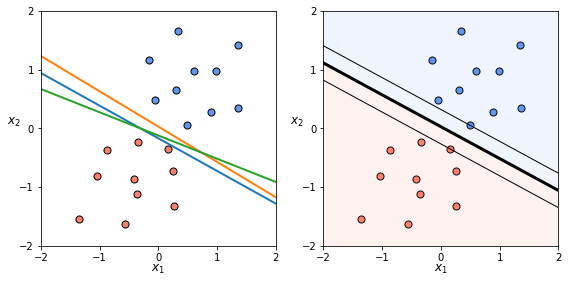

In [5]:
# load in dataset
data = np.loadtxt(data_path_1, delimiter = ',')

# define the input and output of our dataset - assuming arbitrary N > 2 here
x = data[:,:-1]
y = data[:,-1]
y.shape = (len(y),1)

# create instance of svm comparision demo
demo5 = section_6_5_helpers.visualizer(data)

# run all 
demo5.svm_comparison()         # compute linear decision boundaries
demo5.svm_comparison_fig()     # plot linear decision boundaries

Note how in the right panel the margins pass through points from both classes - equidistant from the SVM linear decision boundary. These points are called *support vectors*, hence the name support vector machine.

##  The SVM and noisy datasets

A very big practical benefit of the softmargin SVM problem is that it allows us it to deal with noisy imperfectly (linearly) separable data - which arise far more commonly in practice than datasets that are perfectly linearly separable.   'Noise' is permittable with the softmargin problem since regardless of the weights $b$ and $\boldsymbol{\omega}$, we always have some data point which is misclassified, i.e., for some $p$ that $\text{max}\left(0,\,1-y_{p}^{\,}\left(b+\mathbf{x}_{p}^{T}\boldsymbol{\omega}\right) \right)>0$.  Such a case makes the first hard-margin formulation of SVMs infeasible, as no such $w_0$ and $\boldsymbol{\omega}$ even exist that satisfy the constraints.   Because we commonly deal with non-separable datasets in practice the softmargin form of SVM is the version that is more frequently used.  

However notice that once we forgo the assumption of perfectly (linear) separability the added value of a 'maximum margin hyperplane' proided by the SVM solution disappears since we *no longer have a margin to begin with*.  Thus with many datasets in practice the softmargin problem does *not* provide a solution remarkably different than the perceptron or even logistic regression.  Actually - with datasets that are not linearly separable - it often returns *exactly* the same solution provided by the perceptron or logistic regression.

To see why this could be the case notice what happens to our softmargin SVM problem if we *smooth* the Margin-Perceptron portion of the cost using the *softmax* (as detailed previously).  This gives a smoothed out soft-margin SVM cost function of the form

\begin{equation}
g\left(b,\boldsymbol{\omega}\right)=\underset{p=1}{\overset{P}{\sum}}\text{log}\left( 1 + e^{-y_{p}\left(b+\mathbf{x}_{p}^{T}\boldsymbol{\omega}\right)}\right) +  \lambda \left \Vert\boldsymbol{\omega}\right\Vert _{2}^{2} 
\end{equation}

which we can also identify as a regularized softmax perceptron or logistic regression.  Thus we can see that all three methods of linear two-class classification we have seen are very deeply connected, and why they tend to provide similar results on realistic (not linearly separabble) datasets.